In [ ]:
# Allow imports from parent directory 
import os, sys
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    sys.path.append(os.path.abspath(".")) 

from src import flops_in_folder
from src import model_train_plot
from src import exponential_moving_average
from src import plot_model_errors_compare
import json
import numpy as np
import matplotlib.pyplot as plt

### Overall Flops in this Notebook:

In [28]:
_, _, _ = flops_in_folder('results/Initial_Lora')

Number of unique result files: 4
Total Training FLOPs: 6.159e+15
Total Evaluation FLOPs: 6.581e+14
Total Combined FLOPs: 6.817e+15
Percentage of Total FLOPs Budget:   6.8168 %


# Training
## Both training and hyperparameter tuning was using by submitting jobs to the HPC which returned json files of metrics
- The results of all tests are stored within the `results` diretory


# Investigating ability to train  (not neccesarily generalise):

- Attempt to Overfit Small data (a single trajectory)
- **learn_rate = 1e-3** (note this is not the default used but it run to show it can work)
- **lora_rank_tune = 4**

- To ensure that the training pipeline is valid, I attempt to overfit on a single training sequence and moniter the training preformance
- In this case the evaluation metric is not important as we are deliberatly overfitting on 2 sequences to ensure training is possible and valid using the base parameters

In [29]:
with open("results/Initial_Lora/Overfit_Train.json", "r") as f:
    results = json.load(f)

# Access the values
train_loss_tracker = results["train_loss_tracker"]    
train_step_tracker = results["train_step_tracker"] 
final_train_loss = train_loss_tracker[-1]
val_loss_final = results["val_loss_final"]

train_loss_tracker = np.array(train_loss_tracker)
train_step_tracker = np.array(train_step_tracker)

In [30]:
# Print metrics
print("Final Train Loss: ", final_train_loss)
print("Final Validation Loss: ", val_loss_final)

Final Train Loss:  0.1828635334968567
Final Validation Loss:  1.519472241997719


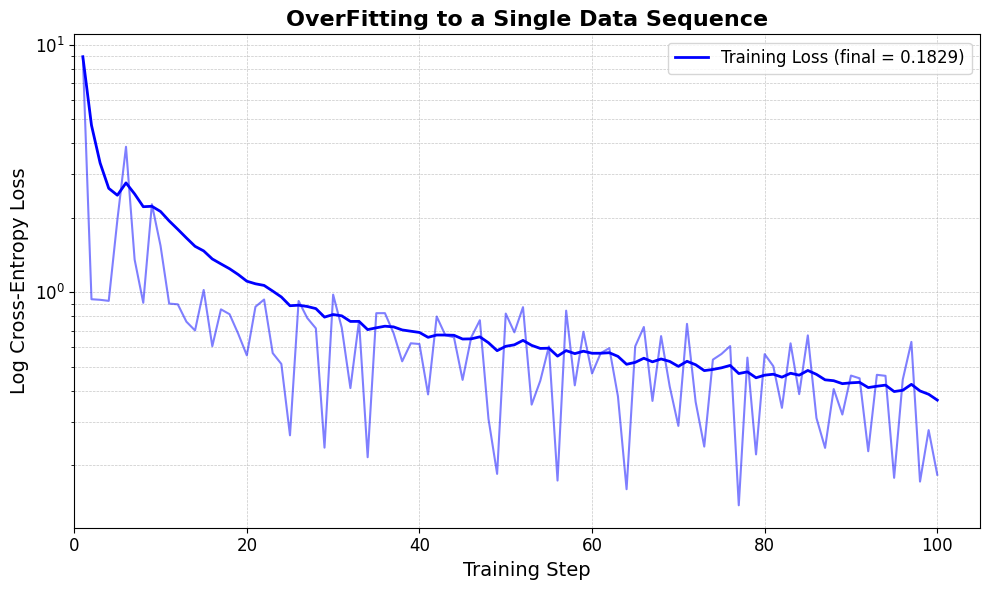

In [31]:
plt.figure(figsize=(10, 6))

# ---- Training Plot (Raw + Time AvSmoothed) ----
plt.plot(train_step_tracker, train_loss_tracker, color='blue', alpha=0.5)
smoothed_train = exponential_moving_average(train_loss_tracker, 0.9)
plt.plot(train_step_tracker, smoothed_train, color='blue', linewidth=2, label=f'Training Loss (final = {final_train_loss:.4f})')

# Titles and labels
plt.title("OverFitting to a Single Data Sequence", fontsize=16, fontweight='bold')
plt.xlabel("Training Step", fontsize=14)
plt.ylabel("Log Cross-Entropy Loss", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(left=0)
plt.xscale('linear')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.yscale('log')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Benchmark - Default Hyperparameters


- In this we aim to test the models ability to learn the full data set and generalise learning across many examples.
- This is run with early stopping with a patience of 5 to ensure that no extra compute is used than needed.
- We use the default hyperparameters given and this result is used within the hyperparameter search
- **learn_rate_tune = 1e-5**
- **lora_rank_tune = 4**


## Terms Explained
- **eval_freq** - this tells the evaluate its preformance ever 25 steps - with unlimited compute this would be more often
- **subset** - this says to evalaute it on 25 random samples from the validation set every time - with ulimited compute this would be higher
    - when evaluating at the end it uses 100 random examples

In [32]:
with open("results/Initial_Lora/Default_Values.json", "r") as f:
    results = json.load(f)

# Access the values
train_loss_tracker = results["train_loss_tracker"]    
train_step_tracker = results["train_step_tracker"] 
val_loss_tracker = results["val_loss_tracker"]
val_step_tracker = results["val_step_tracker"]
training_flops_base = results["training_flops"]
total_eval_cost_base = results["total_eval_cost"]
final_train_loss = train_loss_tracker[-1]
val_loss_final = results["val_loss_final"]
early_stopping_step = results["early_stopping_step"]

train_loss_tracker = np.array(train_loss_tracker)
train_step_tracker = np.array(train_step_tracker)


In [33]:
# Print metrics
print("Final Train Loss: ", final_train_loss)
print("Final Validation Loss: ", val_loss_final)
print(f"Total Training FLOPS: {training_flops_base:.3e}")
print(f"Total Evaluation Cost: {total_eval_cost_base:.3e}")

Final Train Loss:  0.9435019493103027
Final Validation Loss:  0.9293942031264305
Total Training FLOPS: 5.796e+15
Total Evaluation Cost: 3.593e+14


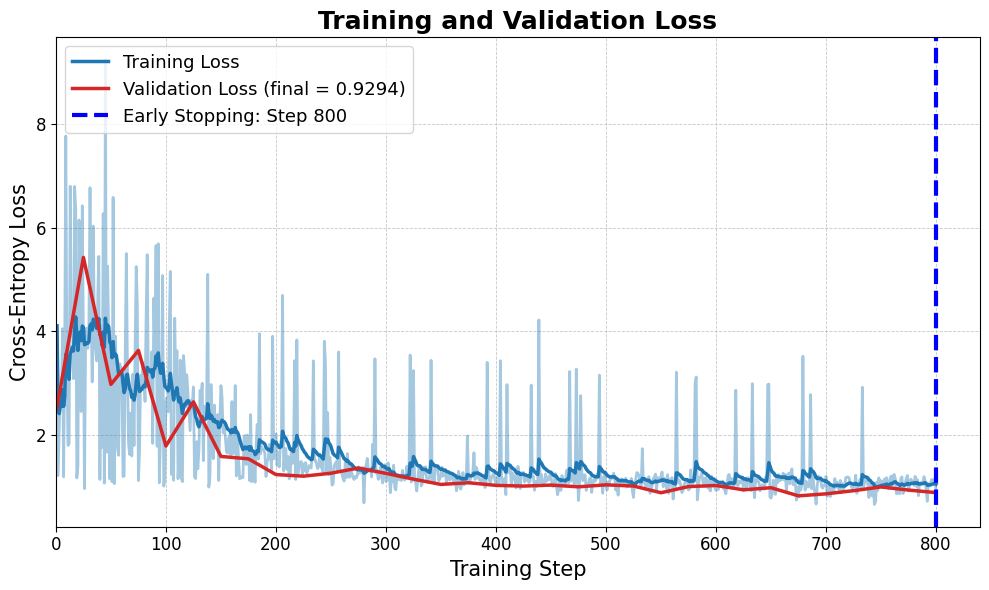

In [34]:
model_train_plot(train_step_tracker, train_loss_tracker, val_step_tracker, val_loss_tracker, val_loss_final, early_stopping_step, log_scale=False)

## Test set metrics on this intial training

# 1. Cross Entropy Loss on Full Test Set

**Final Test Loss: 1.0687**

**Initial Test Loss (for comparison): 4.7794**

In [35]:
with open("results/Initial_Lora/Default_Testloss.json", "r") as f:
    results = json.load(f)
# Load data from tables 
Test_loss =results["test_loss"]

print(f"Final Train Loss: {Test_loss:.4f}")

Final Train Loss: 1.0687


## Test autoregressive loss

# 2. MSE/ MAE/ MAPE for the Test Set
- This analysis gives the MSE, MAE and MAPE for over a give number of random tests as a function of time step.

In [36]:
with open("results/Initial_Lora/Default_Gen.json", "r") as f:
    results_trained = json.load(f)

with open("results/Evaluation/InitialQwenAnalysis.json", "r") as f:
    results_untrained = json.load(f)


prey_original_trained = np.array(results_trained["prey_original"])
predator_original_trained = np.array(results_trained["predator_original"])
prey_generated_trained = np.array(results_trained["prey_generated"])
predator_generated_trained = np.array(results_trained["predator_generated"])

prey_original_untrained = np.array(results_untrained["prey_original"])
predator_original_untrained = np.array(results_untrained["predator_original"])
prey_generated_untrained = np.array(results_untrained["prey_generated"])
predator_generated_untrained = np.array(results_untrained["predator_generated"])

/Users/jacobtutt/Desktop/MPhil_DIS/M2/Coursework_M2/src/analysis.py:746: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


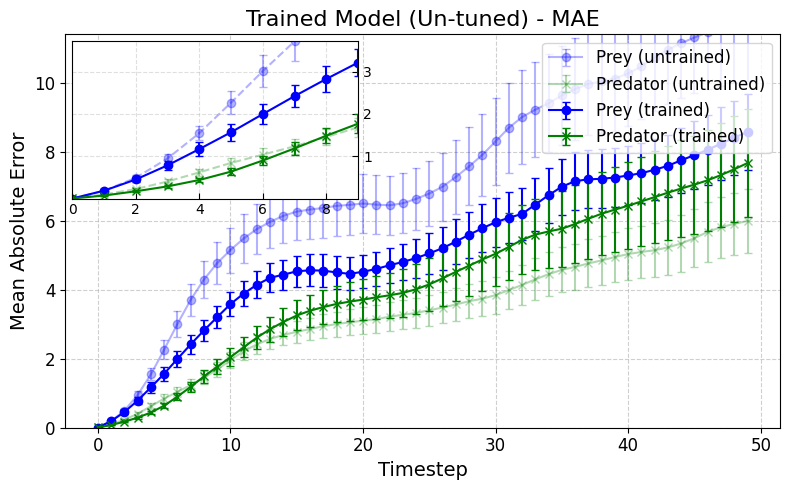

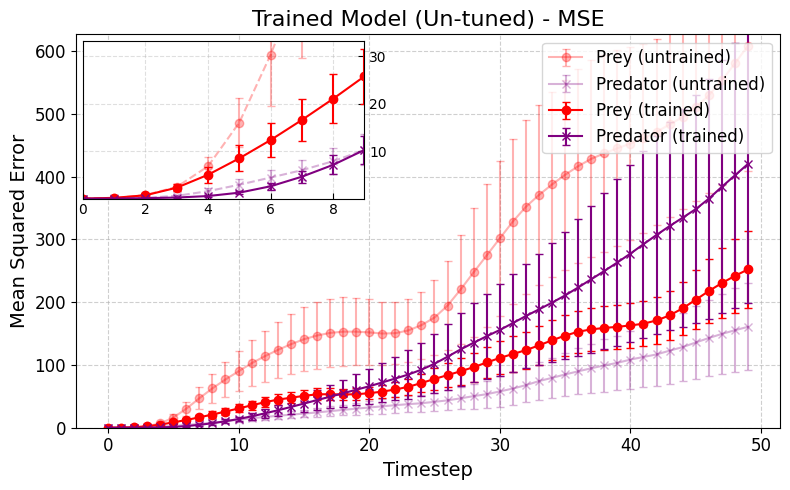

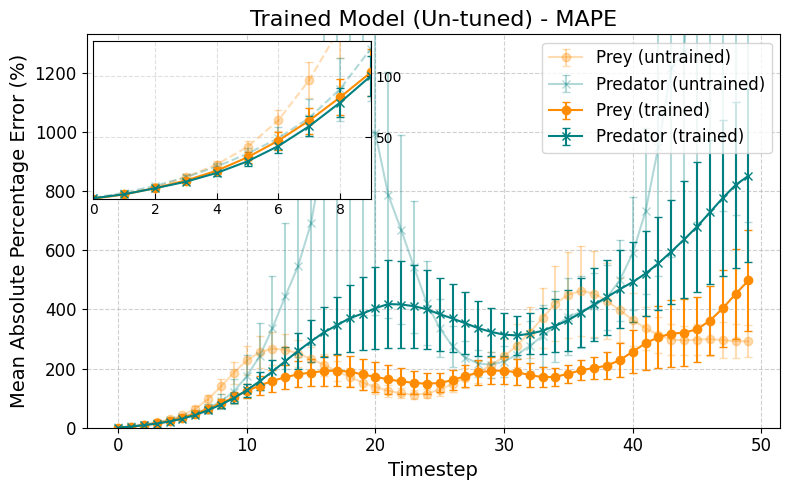

,Timestep,MAE Prey,MAE Predator,MSE Prey,MSE Predator,MAPE Prey (%),MAPE Predator (%)
0,0,0.006 ± 0.003 (-392.8%),0.007 ± 0.002 (56.2%),0.001 ± 0.001 (-1498.1%),0.000 ± 0.000 (78.8%),0.07 ± 0.03 (-367.7%),0.38 ± 0.08 (49.3%)
1,1,0.191 ± 0.030 (0.2%),0.077 ± 0.010 (24.0%),0.168 ± 0.078 (-26.1%),0.022 ± 0.011 (35.0%),3.47 ± 0.41 (6.9%),3.63 ± 0.31 (25.3%)
2,2,0.456 ± 0.058 (7.9%),0.177 ± 0.021 (23.1%),0.707 ± 0.200 (8.2%),0.099 ± 0.033 (45.4%),8.65 ± 0.83 (5.5%),8.50 ± 0.77 (18.6%)
3,3,0.790 ± 0.107 (17.1%),0.292 ± 0.031 (28.2%),2.304 ± 0.727 (6.4%),0.229 ± 0.055 (61.0%),14.82 ± 1.51 (16.1%),13.84 ± 1.29 (20.9%)
4,4,1.173 ± 0.158 (24.3%),0.443 ± 0.049 (28.9%),5.023 ± 1.659 (26.2%),0.545 ± 0.134 (65.3%),22.84 ± 2.73 (18.0%),21.01 ± 2.19 (19.7%)
5,5,1.570 ± 0.202 (30.8%),0.641 ± 0.076 (24.2%),8.485 ± 2.742 (47.0%),1.256 ± 0.328 (57.1%),33.75 ± 4.63 (20.2%),30.48 ± 3.52 (17.0%)
6,6,1.998 ± 0.238 (33.7%),0.903 ± 0.110 (13.3%),12.334 ± 3.666 (59.3%),2.600 ± 0.702 (41.5%),47.39 ± 7.31 (25.9%),42.92 ± 5.41 (13.0%)
7,7,2.422 ± 0.270 (34.8%),1.189 ± 0.148 (4.0%),16.559 ± 4.443 (64.7%),4.616 ± 1.289 (22.9%),63.67 ± 10.67 (34.2%),59.10 ± 8.38 (10.3%)
8,8,2.827 ± 0.298 (34.3%),1.488 ± 0.183 (-2.0%),21.026 ± 5.131 (66.5%),7.116 ± 1.994 (9.7%),82.65 ± 14.55 (40.7%),78.35 ± 11.89 (12.3%)
9,9,3.213 ± 0.324 (32.8%),1.772 ± 0.220 (-5.1%),25.754 ± 5.789 (66.5%),10.257 ± 2.914 (-0.0%),102.99 ± 19.24 (44.7%),100.09 ± 16.32 (18.2%)


In [37]:
plot_model_errors_compare( prey_original_trained, predator_original_trained, prey_generated_trained,
    predator_generated_trained, prey_original_untrained, predator_original_untrained,
    prey_generated_untrained, predator_generated_untrained, draw_context=None,
    title_prefix="Trained Model (Un-tuned)")